In [ ]:
#Cell 1 — Install
!pip -q install datasets

In [ ]:
#Cell 2 — Imports + seed + device
import re, math, time, random
from collections import Counter
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset

import numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
#Cell 3 — Load WikiText-103 + normalize
ds = load_dataset("wikitext", "wikitext-103-raw-v1")

train_text = "\n".join(ds["train"]["text"])
val_text   = "\n".join(ds["validation"]["text"])
test_text  = "\n".join(ds["test"]["text"])

def normalize_space(s: str) -> str:
    s = re.sub(r"[ \t]+", " ", s)
    s = re.sub(r"\n{3,}", "\n\n", s)
    return s.strip()

train_text = normalize_space(train_text)
val_text   = normalize_space(val_text)
test_text  = normalize_space(test_text)

train_text_small = train_text[:200_000]
val_text_small   = val_text[:200_000]
test_text_small  = test_text[:200_000]

len(train_text_small), len(val_text_small), len(test_text_small)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-103-raw-v1/test-00000-of-00001.(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/validation-00000-of-(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

(200000, 200000, 200000)

In [ ]:
#Cell 4 — pretokenizer (English word-ish tokens)
def pretokenize_english(s: str) -> List[str]:
    """
    Pretokenize into word-ish units to speed up BPE training.
    Keeps leading space attached: ' the', ' verdict'
    Splits punctuation and newlines into separate tokens.
    """
    # order matters: handle paragraph breaks/newlines first
    pattern = r"\n\n|\n| ?[A-Za-z]+| ?\d+| ?[^A-Za-z0-9\s]+| +"
    return re.findall(pattern, s)


def pretokenize_chars(s: str) -> List[str]:
    # Character-level base tokens
    return list(s)

In [ ]:
#Cell 5 — NEW IDEA function (paper contribution)
def significance_gain_score(
    cxy: int,
    cx: int,
    cy: int,
    N: int,
    eps: float = 1e-9,
    alpha: float = 0.25,
    use_gain: bool = True,
    lambda_rare: float = 0.0,
) -> float:
    """
    NEW IDEA: Significance-Gain score for BPE merges.

    Null model: independence
      E(xy) = cx * cy / N

    Surprise:
      z = (cxy - E) / sqrt(E + eps)

    Tempering:
      z <- z * (cxy ** alpha)

    Compression-aware gain:
      gain ≈ cxy

    Optional rare penalty:
      lambda_rare / sqrt(cxy)
    """
    N = max(N, 1)
    expected = (cx * cy) / N
    z = (cxy - expected) / math.sqrt(expected + eps)

    if alpha and alpha > 0:
        z = z * (cxy ** alpha)

    gain = float(cxy) if use_gain else 1.0
    pen = (lambda_rare / math.sqrt(cxy + eps)) if (lambda_rare and lambda_rare > 0) else 0.0
    return gain * z - pen

In [ ]:
#Cell 6 — Tokenizer config + tokenizer class
@dataclass
class BPEConfig:
    vocab_size: int = 2000
    min_pair_count: int = 5
    eps: float = 1e-9
    unk_token: str = "<unk>"

    # New-idea knobs
    alpha_count: float = 0.25
    use_gain: bool = True
    lambda_rare: float = 0.0


class SimpleBPE:
    def __init__(self, config: BPEConfig, mode: str = "freq"):
        assert mode in ("freq", "sigz")
        self.cfg = config
        self.mode = mode
        self.merges: List[Tuple[Tuple[str, str], str]] = []
        self.vocab: Dict[str, int] = {}
        self.id_to_tok: List[str] = []

    def _get_pair_counts(self, seq: List[str]) -> Counter:
        return Counter(zip(seq, seq[1:]))

    def _get_symbol_counts(self, seq: List[str]) -> Counter:
        return Counter(seq)

    def _apply_merge_once(self, seq: List[str], pair: Tuple[str, str], merged: str) -> List[str]:
        a, b = pair
        out = []
        i = 0
        L = len(seq)
        while i < L:
            if i < L - 1 and seq[i] == a and seq[i + 1] == b:
                out.append(merged)
                i += 2
            else:
                out.append(seq[i])
                i += 1
        return out

    def _choose_best_pair(self, seq: List[str]) -> Optional[Tuple[str, str]]:
        pair_counts = self._get_pair_counts(seq)
        candidates = [(p, c) for p, c in pair_counts.items() if c >= self.cfg.min_pair_count]
        if not candidates:
            return None

        # Baseline BPE = max count
        if self.mode == "freq":
            best_pair, _ = max(candidates, key=lambda x: x[1])
            return best_pair

        # NEW IDEA = maximize significance_gain_score
        sym_counts = self._get_symbol_counts(seq)
        N = max(len(seq) - 1, 1)

        best_pair = None
        best_score = -1e30
        for (a, b), cxy in candidates:
            cx = sym_counts[a]
            cy = sym_counts[b]
            score = significance_gain_score(
                cxy=cxy, cx=cx, cy=cy, N=N,
                eps=self.cfg.eps,
                alpha=self.cfg.alpha_count,
                use_gain=self.cfg.use_gain,
                lambda_rare=self.cfg.lambda_rare
            )
            if score > best_score:
                best_score = score
                best_pair = (a, b)
        return best_pair

    def train(self, text: str, progress_every: int = 200):

        seq = pretokenize_chars(text)

        # base vocab from TRAIN pre-tokens + <unk>
        base_vocab = sorted(set(seq))
        if self.cfg.unk_token not in base_vocab:
            base_vocab.append(self.cfg.unk_token)

        self.merges = []

        def current_vocab_size(s):
            return len(set(s))


        #target = max(self.cfg.vocab_size, current_vocab_size(seq))
        target = self.cfg.vocab_size
        t0 = time.time()
        it = 0

        while current_vocab_size(seq) < target:
            best_pair = self._choose_best_pair(seq)
            if best_pair is None:
                break

            merged = best_pair[0] + best_pair[1]
            self.merges.append((best_pair, merged))
            seq = self._apply_merge_once(seq, best_pair, merged)

            it += 1
            if it % progress_every == 0:
                print(f"[{self.mode}] merges={it} vocab={current_vocab_size(seq)} elapsed={time.time()-t0:.1f}s")

            if it > 20000:
                print("[warn] stopping at 20000 merges (safety).")
                break

        # Final vocab
        tokens = set(base_vocab)
        for (_, _), merged in self.merges:
            tokens.add(merged)
        tokens.add(self.cfg.unk_token)

        self.id_to_tok = sorted(tokens)
        self.vocab = {t: i for i, t in enumerate(self.id_to_tok)}
        print(f"[{self.mode}] training done: merges={len(self.merges)} final_vocab={len(self.vocab)}")

    def encode(self, text: str) -> List[int]:
        UNK = self.cfg.unk_token
        unk_id = self.vocab[UNK]

        seq = pretokenize_chars(text)

        # Map unseen base tokens to UNK (should be rare with same domain)
        seq = [t if t in self.vocab else UNK for t in seq]

        for (a, b), merged in self.merges:
            seq = self._apply_merge_once(seq, (a, b), merged)

        return [self.vocab.get(t, unk_id) for t in seq]

    def stats(self, encoded: List[int], raw_text: str) -> Dict[str, float]:
        toks = len(encoded)
        chars = max(len(raw_text), 1)
        used = len(set(encoded))
        util = used / max(len(self.vocab), 1)
        return {
            "tokens_per_char": toks / chars,
            "vocab_used_frac": util,
            "num_tokens": toks,
            "num_chars": chars,
        }

In [ ]:
#Cell 7 — Train tokenizers + encode + show stats
def show_stats(name, tok, tr, va, te, train_text, val_text, test_text):
    st_tr = tok.stats(tr, train_text)
    st_va = tok.stats(va, val_text)
    st_te = tok.stats(te, test_text)
    print(f"\n{name}")
    print(f"  train tpc={st_tr['tokens_per_char']:.4f}  vocab_used={st_tr['vocab_used_frac']:.3f}")
    print(f"  val   tpc={st_va['tokens_per_char']:.4f}  vocab_used={st_va['vocab_used_frac']:.3f}")
    print(f"  test  tpc={st_te['tokens_per_char']:.4f}  vocab_used={st_te['vocab_used_frac']:.3f}")

vocab_size = 600
tok_freq = SimpleBPE(BPEConfig(vocab_size=vocab_size, min_pair_count=5, alpha_count=0.0), mode="freq")
tok_sigz = SimpleBPE(BPEConfig(vocab_size=vocab_size, min_pair_count=5, alpha_count=0.25, use_gain=True), mode="sigz")

print("Training standard BPE...")
tok_freq.train(train_text_small, progress_every=200)

print("\nTraining significance-gain BPE...")
tok_sigz.train(train_text_small, progress_every=200)

tr_f = tok_freq.encode(train_text_small)
va_f = tok_freq.encode(val_text_small)
te_f = tok_freq.encode(test_text_small)

tr_s = tok_sigz.encode(train_text_small)
va_s = tok_sigz.encode(val_text_small)
te_s = tok_sigz.encode(test_text_small)

show_stats("BPE freq", tok_freq, tr_f, va_f, te_f, train_text_small, val_text_small, test_text_small)
show_stats("BPE sigz (gain*z)", tok_sigz, tr_s, va_s, te_s, train_text_small, val_text_small, test_text_small)

Training standard BPE...
[freq] merges=200 vocab=340 elapsed=7.1s
[freq] merges=400 vocab=533 elapsed=13.1s
[freq] training done: merges=469 final_vocab=617

Training significance-gain BPE...
[sigz] merges=200 vocab=335 elapsed=9.4s
[sigz] merges=400 vocab=517 elapsed=17.4s
[sigz] training done: merges=487 final_vocab=635

BPE freq
  train tpc=0.4052  vocab_used=0.972
  val   tpc=0.4364  vocab_used=0.864
  test  tpc=0.4307  vocab_used=0.851

BPE sigz (gain*z)
  train tpc=0.4080  vocab_used=0.945
  val   tpc=0.4430  vocab_used=0.825
  test  tpc=0.4366  vocab_used=0.814


In [ ]:
#Cell 8 — Dataset blocks for LM
class LMBlocks(Dataset):
    def __init__(self, ids: List[int], block_size: int = 256, stride: int = 256):
        self.ids = torch.tensor(ids, dtype=torch.long)
        self.block = block_size
        self.starts = list(range(0, max(len(self.ids) - block_size - 1, 0), stride))

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, idx):
        s = self.starts[idx]
        x = self.ids[s:s+self.block]
        y = self.ids[s+1:s+self.block+1]
        return x, y

In [ ]:
#Cell 9 — Tiny GPT model
class CausalSelfAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float):
        super().__init__()
        assert d_model % n_heads == 0
        self.nh = n_heads
        self.dk = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.chunk(3, dim=-1)

        q = q.view(B, T, self.nh, self.dk).transpose(1, 2)
        k = k.view(B, T, self.nh, self.dk).transpose(1, 2)
        v = v.view(B, T, self.nh, self.dk).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.dk)
        mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1)
        att = att.masked_fill(mask, float("-inf"))
        att = F.softmax(att, dim=-1)
        att = self.drop(att)

        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.drop(self.proj(y))
        return y

class TransformerBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float, mlp_mult: int = 4):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_mult * d_model),
            nn.GELU(),
            nn.Linear(mlp_mult * d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class TinyGPT(nn.Module):
    def __init__(self, vocab_size: int, block_size: int, d_model=192, n_heads=4, n_layers=4, dropout=0.1):
        super().__init__()
        self.block_size = block_size
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(block_size, d_model)
        self.drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, n_heads, dropout) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, idx):
        B, T = idx.shape
        pos = torch.arange(0, T, device=idx.device)
        x = self.tok_emb(idx) + self.pos_emb(pos)[None, :, :]
        x = self.drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.ln_f(x)
        return self.head(x)

In [ ]:
#Cell 10 — Train/eval helpers
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    correct = 0

    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), reduction="sum")
        total_loss += loss.item()
        total_tokens += y.numel()

        pred = logits.argmax(dim=-1)
        correct += (pred == y).sum().item()

    avg_nll = total_loss / max(total_tokens, 1)
    ppl = math.exp(min(avg_nll, 20))
    acc = correct / max(total_tokens, 1)
    return avg_nll, ppl, acc

def train_lm(train_ids, val_ids, vocab_size, block_size=256, batch_size=64, epochs=3, lr=3e-4):
    train_ds = LMBlocks(train_ids, block_size=block_size, stride=block_size)
    val_ds   = LMBlocks(val_ids, block_size=block_size, stride=block_size)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = TinyGPT(vocab_size=vocab_size, block_size=block_size).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)

    for ep in range(1, epochs + 1):
        model.train()
        t0 = time.time()
        running = 0.0
        tokens = 0

        for x, y in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            running += loss.item() * y.numel()
            tokens += y.numel()

        train_nll = running / max(tokens, 1)
        val_nll, val_ppl, val_acc = evaluate(model, val_loader, device)
        print(f"epoch {ep:02d} | train_nll={train_nll:.4f} | val_nll={val_nll:.4f} | val_ppl={val_ppl:.2f} | val_acc={val_acc*100:.2f}% | {time.time()-t0:.1f}s")

    return model

Using device: cuda

ABLATIONS (multi-seed results)
[freq] merges=200 vocab=340 elapsed=7.4s
[freq] training done: merges=262 final_vocab=410

Tokenizer: Freq-BPE | merges=262 | vocab=410 | tpc(val)=0.4848 tpc(test)=0.4827

--- Freq-BPE (first 25 merges in training order) ---
01: ('e', ' ') -> 'e '
02: ('s', ' ') -> 's '
03: ('t', 'h') -> 'th'
04: ('d', ' ') -> 'd '
05: ('n', ' ') -> 'n '
06: ('e', 'r') -> 'er'
07: ('t', ' ') -> 't '
08: ('th', 'e ') -> 'the '
09: ('i', 'n') -> 'in'
10: ('a', 'n') -> 'an'
11: (',', ' ') -> ', '
12: ('e', 'd ') -> 'ed '
13: ('o', 'r') -> 'or'
14: ('y', ' ') -> 'y '
15: ('.', ' ') -> '. '
16: ('a', 'r') -> 'ar'
17: ('a', 'l') -> 'al'
18: ('t', 'i') -> 'ti'
19: ('o', ' ') -> 'o '
20: ('er', ' ') -> 'er '
21: ('o', 'f') -> 'of'
22: ('r', 'e') -> 're'
23: ('o', 'n') -> 'on'
24: ('of', ' ') -> 'of '
25: ('in', 'g') -> 'ing'
epoch 01 | train_nll=6.0831 | val_nll=5.9174 | val_ppl=371.43 | val_acc=1.25% | 2.1s
epoch 02 | train_nll=5.8179 | val_nll=5.6579 | val_p

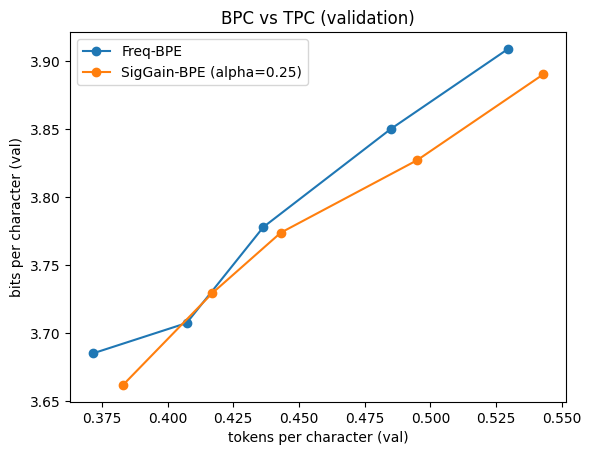


MATCHED COMPRESSION (closest val TPC)

SigGain V= 300 (tpc=0.5430, val_bpc=3.8903)  vs  Freq V= 300 (tpc=0.5295, val_bpc=3.9089)  | ΔBPC=+0.0186

SigGain V= 400 (tpc=0.4949, val_bpc=3.8271)  vs  Freq V= 400 (tpc=0.4848, val_bpc=3.8500)  | ΔBPC=+0.0228

SigGain V= 600 (tpc=0.4430, val_bpc=3.7739)  vs  Freq V= 600 (tpc=0.4364, val_bpc=3.7780)  | ΔBPC=+0.0042

SigGain V= 800 (tpc=0.4170, val_bpc=3.7295)  vs  Freq V= 800 (tpc=0.4072, val_bpc=3.7075)  | ΔBPC=-0.0220

SigGain V=1200 (tpc=0.3831, val_bpc=3.6621)  vs  Freq V=1200 (tpc=0.3715, val_bpc=3.6852)  | ΔBPC=+0.0231


In [ ]:
# =========================
# CELL 11— experiment runner:
# multi-seed, vocab grid, ablations, BPC vs TPC plots, top merges
# =========================

import math
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

LN2 = math.log(2.0)

def nll_char(nll_tok: float, tokens_per_char: float) -> float:
    return nll_tok * tokens_per_char

def bpc(nll_tok: float, tokens_per_char: float) -> float:
    return nll_char(nll_tok, tokens_per_char) / LN2

def mean_std(xs):
    xs = np.array(xs, dtype=float)
    return float(xs.mean()), float(xs.std(ddof=1)) if len(xs) > 1 else 0.0

def print_top_merges(tok, k=30, title="Top merges"):
    print(f"\n--- {title} (first {k} merges in training order) ---")
    for i, ((a,b), ab) in enumerate(tok.merges[:k], 1):
        # show whitespace clearly
        aa = a.replace("\n", "\\n")
        bb = b.replace("\n", "\\n")
        abab = ab.replace("\n", "\\n")
        print(f"{i:02d}: ({aa!r}, {bb!r}) -> {abab!r}")

def build_tokenizer(mode: str, cfg: BPEConfig):
    return SimpleBPE(cfg, mode=mode)

def train_tokenizer_and_encode(cfg: BPEConfig, mode: str,
                              train_text, val_text, test_text):
    """
    Trains tokenizer ONCE, encodes all splits ONCE.
    Returns tok, encoded ids, tpc stats.
    """
    tok = build_tokenizer(mode, cfg)
    tok.train(train_text)

    tr_ids = tok.encode(train_text)
    va_ids = tok.encode(val_text)
    te_ids = tok.encode(test_text)

    st_tr = tok.stats(tr_ids, train_text)
    st_va = tok.stats(va_ids, val_text)
    st_te = tok.stats(te_ids, test_text)

    out = {
        "tok": tok,
        "tr": tr_ids,
        "va": va_ids,
        "te": te_ids,
        "tpc_tr": st_tr["tokens_per_char"],
        "tpc_va": st_va["tokens_per_char"],
        "tpc_te": st_te["tokens_per_char"],
        "vocab_size": len(tok.vocab),
        "merges": len(tok.merges),
    }
    return out

def run_lm_multi_seed(tr_ids, va_ids, te_ids, vocab_size,
                      seeds=(1,2,3,4,5), block_size=256, epochs=3, batch_size=64):
    """
    Train/eval LM across multiple seeds. Returns lists of metrics per seed.
    Uses existing train_lm(...) and evaluate(...).
    """
    val_ppl_list, test_ppl_list = [], []
    val_nll_list, test_nll_list = [], []
    val_acc_list, test_acc_list = [], []

    for s in seeds:
        set_seed(s)

        model = train_lm(tr_ids, va_ids, vocab_size=vocab_size,
                         block_size=block_size, epochs=epochs)

        val_loader = DataLoader(LMBlocks(va_ids, block_size=block_size, stride=block_size),
                                batch_size=batch_size, shuffle=False)
        te_loader  = DataLoader(LMBlocks(te_ids, block_size=block_size, stride=block_size),
                                batch_size=batch_size, shuffle=False)

        val_nll, val_ppl, val_acc = evaluate(model, val_loader, device)
        te_nll,  te_ppl,  te_acc  = evaluate(model, te_loader, device)

        val_ppl_list.append(val_ppl); test_ppl_list.append(te_ppl)
        val_nll_list.append(val_nll); test_nll_list.append(te_nll)
        val_acc_list.append(val_acc); test_acc_list.append(te_acc)

        hard_cleanup(model)
        torch.cuda.empty_cache()

    return {
        "val_ppl": val_ppl_list, "test_ppl": test_ppl_list,
        "val_nll": val_nll_list, "test_nll": test_nll_list,
        "val_acc": val_acc_list, "test_acc": test_acc_list,
    }

def summarize_run(name, lm_metrics, tpc_va, tpc_te):
    """
    Converts LM metrics into mean±std for PPL and BPC (tokenizer-invariant).
    """
    val_ppl_m, val_ppl_s = mean_std(lm_metrics["val_ppl"])
    test_ppl_m, test_ppl_s = mean_std(lm_metrics["test_ppl"])

    # Convert NLL/token -> BPC using tpc
    val_bpc_list  = [bpc(nll, tpc_va) for nll in lm_metrics["val_nll"]]
    test_bpc_list = [bpc(nll, tpc_te) for nll in lm_metrics["test_nll"]]
    val_bpc_m, val_bpc_s = mean_std(val_bpc_list)
    test_bpc_m, test_bpc_s = mean_std(test_bpc_list)

    print(f"\n{name}")
    print(f"  Val  PPL: {val_ppl_m:.2f} ± {val_ppl_s:.2f}")
    print(f"  Test PPL: {test_ppl_m:.2f} ± {test_ppl_s:.2f}")
    print(f"  Val  BPC: {val_bpc_m:.4f} ± {val_bpc_s:.4f}   (tpc={tpc_va:.4f})")
    print(f"  Test BPC: {test_bpc_m:.4f} ± {test_bpc_s:.4f}   (tpc={tpc_te:.4f})")

    return {
        "val_ppl_mean": val_ppl_m, "val_ppl_std": val_ppl_s,
        "test_ppl_mean": test_ppl_m, "test_ppl_std": test_ppl_s,
        "val_bpc_mean": val_bpc_m, "val_bpc_std": val_bpc_s,
        "test_bpc_mean": test_bpc_m, "test_bpc_std": test_bpc_s,
        "tpc_va": tpc_va, "tpc_te": tpc_te,
    }

# -------------------------
# CONFIG: choose seeds, vocab grid, epochs
# -------------------------
SEEDS = [1,2,3,4,5]
EPOCHS = 3
BLOCK_SIZE = 256
BATCH_SIZE = 64

# Grid of vocab sizes (for BPC vs TPC curves)
VOCAB_GRID = [300, 400, 600, 800, 1200]

# Base fairness knobs (keep same across all tokenizers)
MIN_PAIR = 5
LAMBDA_RARE = 0.0

# -------------------------
# 1) ABLATIONS at ONE vocab size
# -------------------------
V0 = 400

ablations = [
    ("Freq-BPE",               ("freq", BPEConfig(vocab_size=V0, min_pair_count=MIN_PAIR, alpha_count=0.0, use_gain=False, lambda_rare=LAMBDA_RARE))),
    ("SigGain alpha=0.00",     ("sigz", BPEConfig(vocab_size=V0, min_pair_count=MIN_PAIR, alpha_count=0.0, use_gain=True,  lambda_rare=LAMBDA_RARE))),
    ("SigGain alpha=0.25",     ("sigz", BPEConfig(vocab_size=V0, min_pair_count=MIN_PAIR, alpha_count=0.25,use_gain=True,  lambda_rare=LAMBDA_RARE))),
    ("SigGain alpha=0.50",     ("sigz", BPEConfig(vocab_size=V0, min_pair_count=MIN_PAIR, alpha_count=0.5, use_gain=True,  lambda_rare=LAMBDA_RARE))),
    ("SigGain alpha=1.00",     ("sigz", BPEConfig(vocab_size=V0, min_pair_count=MIN_PAIR, alpha_count=1.0, use_gain=True,  lambda_rare=LAMBDA_RARE))),
    ("SigOnly (no gain)",      ("sigz", BPEConfig(vocab_size=V0, min_pair_count=MIN_PAIR, alpha_count=0.25,use_gain=False, lambda_rare=LAMBDA_RARE))),
]

print("\n==============================")
print("ABLATIONS (multi-seed results)")
print("==============================")

ablation_summaries = []
for name, (mode, cfg) in ablations:
    pack = train_tokenizer_and_encode(cfg, mode, train_text_small, val_text_small, test_text_small)

    print(f"\nTokenizer: {name} | merges={pack['merges']} | vocab={pack['vocab_size']} | "
          f"tpc(val)={pack['tpc_va']:.4f} tpc(test)={pack['tpc_te']:.4f}")

    # Qualitative: show merges for the main baseline + main siggain
    if name in ("Freq-BPE", "SigGain alpha=0.25"):
        print_top_merges(pack["tok"], k=25, title=f"{name}")

    lm = run_lm_multi_seed(pack["tr"], pack["va"], pack["te"],
                           vocab_size=pack["vocab_size"],
                           seeds=SEEDS, block_size=BLOCK_SIZE,
                           epochs=EPOCHS, batch_size=BATCH_SIZE)

    summ = summarize_run(name, lm, pack["tpc_va"], pack["tpc_te"])
    summ["name"] = name
    summ["mode"] = mode
    summ["vocab_target"] = cfg.vocab_size
    summ["merges"] = pack["merges"]
    ablation_summaries.append(summ)

# -------------------------
# 2) BPC vs TPC curves over a vocab grid
# -------------------------
print("\n==============================")
print("VOCAB GRID (BPC vs TPC curves)")
print("==============================")

grid_rows = []

for V in VOCAB_GRID:
    # Frequency baseline
    cfg_f = BPEConfig(vocab_size=V, min_pair_count=MIN_PAIR, alpha_count=0.0, use_gain=False, lambda_rare=LAMBDA_RARE)
    pack_f = train_tokenizer_and_encode(cfg_f, "freq", train_text_small, val_text_small, test_text_small)
    lm_f = run_lm_multi_seed(pack_f["tr"], pack_f["va"], pack_f["te"],
                             vocab_size=pack_f["vocab_size"],
                             seeds=SEEDS, block_size=BLOCK_SIZE,
                             epochs=EPOCHS, batch_size=BATCH_SIZE)
    summ_f = summarize_run(f"Freq-BPE (V={V})", lm_f, pack_f["tpc_va"], pack_f["tpc_te"])
    summ_f.update({"tokenizer":"freq", "V":V})

    # SigGain main setting
    cfg_s = BPEConfig(vocab_size=V, min_pair_count=MIN_PAIR, alpha_count=0.25, use_gain=True, lambda_rare=LAMBDA_RARE)
    pack_s = train_tokenizer_and_encode(cfg_s, "sigz", train_text_small, val_text_small, test_text_small)
    lm_s = run_lm_multi_seed(pack_s["tr"], pack_s["va"], pack_s["te"],
                             vocab_size=pack_s["vocab_size"],
                             seeds=SEEDS, block_size=BLOCK_SIZE,
                             epochs=EPOCHS, batch_size=BATCH_SIZE)
    summ_s = summarize_run(f"SigGain (V={V})", lm_s, pack_s["tpc_va"], pack_s["tpc_te"])
    summ_s.update({"tokenizer":"siggain", "V":V})

    grid_rows.append(summ_f)
    grid_rows.append(summ_s)

# Plot BPC vs TPC (validation)
freq_pts = [(r["tpc_va"], r["val_bpc_mean"]) for r in grid_rows if r["tokenizer"]=="freq"]
sig_pts  = [(r["tpc_va"], r["val_bpc_mean"]) for r in grid_rows if r["tokenizer"]=="siggain"]

plt.figure()
plt.plot([x for x,_ in freq_pts], [y for _,y in freq_pts], marker="o", label="Freq-BPE")
plt.plot([x for x,_ in sig_pts],  [y for _,y in sig_pts],  marker="o", label="SigGain-BPE (alpha=0.25)")
plt.xlabel("tokens per character (val)")
plt.ylabel("bits per character (val)")
plt.title("BPC vs TPC (validation)")
plt.legend()
plt.show()

# -------------------------
# 3) Match-compression comparison (closest TPC)
# -------------------------
print("\n=========================================")
print("MATCHED COMPRESSION (closest val TPC)")
print("=========================================")

freq_grid = [r for r in grid_rows if r["tokenizer"]=="freq"]
sig_grid  = [r for r in grid_rows if r["tokenizer"]=="siggain"]

def closest_by_tpc(target_tpc, candidates):
    return min(candidates, key=lambda r: abs(r["tpc_va"] - target_tpc))

for r_sig in sig_grid:
    r_freq = closest_by_tpc(r_sig["tpc_va"], freq_grid)
    print(f"\nSigGain V={r_sig['V']:>4} (tpc={r_sig['tpc_va']:.4f}, val_bpc={r_sig['val_bpc_mean']:.4f})"
          f"  vs  Freq V={r_freq['V']:>4} (tpc={r_freq['tpc_va']:.4f}, val_bpc={r_freq['val_bpc_mean']:.4f})"
          f"  | ΔBPC={r_freq['val_bpc_mean']-r_sig['val_bpc_mean']:+.4f}")

In [ ]:
# Cell 13 — Train both LMs + final comparison (also reports tokenizer-invariant BPC)
import math

block_size = 256
epochs = 8

# --- Helper: tokenizer-invariant metrics ---
LN2 = math.log(2.0)

def nll_char(nll_tok: float, tokens_per_char: float) -> float:
    """Convert NLL per token (nats/token) to NLL per character (nats/char)."""
    return nll_tok * tokens_per_char

def bpc(nll_tok: float, tokens_per_char: float) -> float:
    """Bits per character (BPC) = (nats/char) / ln(2)."""
    return nll_char(nll_tok, tokens_per_char) / LN2

def pct_improve(old, new):
    return (old - new) / old * 100.0

print("\n=== Train LM with standard BPE ===")
model_f = train_lm(tr_f, va_f, vocab_size=len(tok_freq.vocab), block_size=block_size, epochs=epochs)

print("\n=== Train LM with significance-gain BPE ===")
model_s = train_lm(tr_s, va_s, vocab_size=len(tok_sigz.vocab), block_size=block_size, epochs=epochs)

# --- Dataloaders ---
val_loader_f = DataLoader(LMBlocks(va_f, block_size=block_size, stride=block_size), batch_size=64, shuffle=False)
val_loader_s = DataLoader(LMBlocks(va_s, block_size=block_size, stride=block_size), batch_size=64, shuffle=False)
te_loader_f  = DataLoader(LMBlocks(te_f, block_size=block_size, stride=block_size), batch_size=64, shuffle=False)
te_loader_s  = DataLoader(LMBlocks(te_s, block_size=block_size, stride=block_size), batch_size=64, shuffle=False)

# --- Evaluate (returns NLL in nats/token, PPL, token-acc) ---
val_nll_f, val_ppl_f, val_acc_f = evaluate(model_f, val_loader_f, device)
val_nll_s, val_ppl_s, val_acc_s = evaluate(model_s, val_loader_s, device)
te_nll_f,  te_ppl_f,  te_acc_f  = evaluate(model_f, te_loader_f, device)
te_nll_s,  te_ppl_s,  te_acc_s  = evaluate(model_s, te_loader_s, device)

# --- Get tokens-per-character for each tokenizer on val/test (from existing tok.stats) ---
st_va_f = tok_freq.stats(va_f, val_text_small)
st_te_f = tok_freq.stats(te_f, test_text_small)
st_va_s = tok_sigz.stats(va_s, val_text_small)
st_te_s = tok_sigz.stats(te_s, test_text_small)

val_tpc_f, test_tpc_f = st_va_f["tokens_per_char"], st_te_f["tokens_per_char"]
val_tpc_s, test_tpc_s = st_va_s["tokens_per_char"], st_te_s["tokens_per_char"]

# --- Tokenizer-invariant metrics: NLL/char + BPC ---
val_nllc_f  = nll_char(val_nll_f, val_tpc_f)
test_nllc_f = nll_char(te_nll_f,  test_tpc_f)
val_bpc_f   = bpc(val_nll_f, val_tpc_f)
test_bpc_f  = bpc(te_nll_f,  test_tpc_f)

val_nllc_s  = nll_char(val_nll_s, val_tpc_s)
test_nllc_s = nll_char(te_nll_s,  test_tpc_s)
val_bpc_s   = bpc(val_nll_s, val_tpc_s)
test_bpc_s  = bpc(te_nll_s,  test_tpc_s)

print("\n====================")
print("FINAL COMPARISON")
print("====================")
print(f"Standard BPE     | val_ppl={val_ppl_f:.2f} | val_acc={val_acc_f*100:.2f}% | test_ppl={te_ppl_f:.2f} | test_acc={te_acc_f*100:.2f}%")
print(f"Significance-BPE | val_ppl={val_ppl_s:.2f} | val_acc={val_acc_s*100:.2f}% | test_ppl={te_ppl_s:.2f} | test_acc={te_acc_s*100:.2f}%")

print("\nTokenizer stats (tokens per char)")
print(f"Standard BPE     | val_tpc={val_tpc_f:.4f} | test_tpc={test_tpc_f:.4f}")
print(f"Significance-BPE | val_tpc={val_tpc_s:.4f} | test_tpc={test_tpc_s:.4f}")

print("\nTokenizer-invariant metrics")
print(f"Standard BPE     | val_nll/char={val_nllc_f:.6f} | test_nll/char={test_nllc_f:.6f} | val_bpc={val_bpc_f:.4f} | test_bpc={test_bpc_f:.4f}")
print(f"Significance-BPE | val_nll/char={val_nllc_s:.6f} | test_nll/char={test_nllc_s:.6f} | val_bpc={val_bpc_s:.4f} | test_bpc={test_bpc_s:.4f}")

print("\nImprovements (lower is better)")
print(f"Val  PPL improvement (%): {pct_improve(val_ppl_f, val_ppl_s):.2f}")
print(f"Test PPL improvement (%): {pct_improve(te_ppl_f,  te_ppl_s):.2f}")
print(f"Val  BPC improvement (%): {pct_improve(val_bpc_f, val_bpc_s):.2f}")
print(f"Test BPC improvement (%): {pct_improve(test_bpc_f, test_bpc_s):.2f}")


=== Train LM with standard BPE ===
epoch 01 | train_nll=6.5319 | val_nll=6.4071 | val_ppl=606.11 | val_acc=0.51% | 0.7s
epoch 02 | train_nll=6.3400 | val_nll=6.1864 | val_ppl=486.08 | val_acc=1.34% | 0.7s
epoch 03 | train_nll=6.1431 | val_nll=6.0055 | val_ppl=405.65 | val_acc=1.48% | 0.7s
epoch 04 | train_nll=6.0065 | val_nll=5.8946 | val_ppl=363.08 | val_acc=1.43% | 0.7s
epoch 05 | train_nll=5.9203 | val_nll=5.8261 | val_ppl=339.02 | val_acc=1.63% | 0.7s
epoch 06 | train_nll=5.8639 | val_nll=5.7852 | val_ppl=325.44 | val_acc=1.84% | 0.7s
epoch 07 | train_nll=5.8312 | val_nll=5.7611 | val_ppl=317.70 | val_acc=1.88% | 0.7s
epoch 08 | train_nll=5.8132 | val_nll=5.7455 | val_ppl=312.78 | val_acc=1.93% | 0.7s

=== Train LM with significance-gain BPE ===
epoch 01 | train_nll=6.5509 | val_nll=6.4079 | val_ppl=606.63 | val_acc=0.61% | 0.7s
epoch 02 | train_nll=6.3243 | val_nll=6.1452 | val_ppl=466.46 | val_acc=1.79% | 0.7s
epoch 03 | train_nll=6.0886 | val_nll=5.9262 | val_ppl=374.75 | val_a